In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem, RDLogger
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt

# Suppress RDKit warnings for cleaner output during generation checks
RDLogger.DisableLog('rdApp.*')

# =========================================
# CONFIGURATION (SIMPLIFIED & TUNED v3)
# =========================================
class Config:
    # --- System & Data Paths ---
    CHEMPL_DB_PATH = 'DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db'
    MODEL_DIR = 'models_simplified_v3' # CHANGED to v3

    # --- Model Hyperparameters (SCALED DOWN) ---
    MAX_ATOMS = 9
    ATOM_LIST = ['C', 'N', 'O', 'F', 'S', 'Cl'] 
    NUM_ATOM_TYPES = len(ATOM_LIST) + 1 
    
    BOND_TYPES = [Chem.rdchem.BondType.ZERO,
                  Chem.rdchem.BondType.SINGLE,
                  Chem.rdchem.BondType.DOUBLE,
                  Chem.rdchem.BondType.TRIPLE,
                  Chem.rdchem.BondType.AROMATIC]
    NUM_BOND_TYPES = len(BOND_TYPES)

    LATENT_DIM = 128
    BATCH_SIZE = 64
    LR_G = 1e-4
    LR_D = 1e-4
    LAMBDA_GP = 10
    N_CRITIC = 5
    NUM_EPOCHS = 500   
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SAVE_EVERY = 10    # CHANGED to save every 10 epochs
    RESUME_EPOCH = None 

print(f"Running on device: {Config.DEVICE}")

# =========================================
# DATA UTILS
# =========================================
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    num_atoms = mol.GetNumAtoms()
    if num_atoms > Config.MAX_ATOMS or num_atoms < 2: return None

    X = np.zeros((Config.MAX_ATOMS, Config.NUM_ATOM_TYPES), dtype=np.float32)
    for i, atom in enumerate(mol.GetAtoms()):
        sym = atom.GetSymbol()
        if sym in Config.ATOM_LIST: X[i, Config.ATOM_LIST.index(sym)] = 1.0
        else: return None 
    for i in range(num_atoms, Config.MAX_ATOMS): X[i, -1] = 1.0

    A = np.zeros((Config.MAX_ATOMS, Config.MAX_ATOMS, Config.NUM_BOND_TYPES), dtype=np.float32)
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        b_type = bond.GetBondType()
        try:
            ch_idx = Config.BOND_TYPES.index(b_type)
            A[i, j, ch_idx] = A[j, i, ch_idx] = 1.0
        except ValueError: continue
    for i in range(Config.MAX_ATOMS):
        for j in range(Config.MAX_ATOMS):
            if np.sum(A[i,j,:]) == 0: A[i,j,0] = 1.0
    return X, A

def graphs_to_mols(node_X, adj_A, hard=True):
    mols = []
    if hard:
        if isinstance(node_X, torch.Tensor): node_X = torch.argmax(node_X, dim=-1).detach().cpu().numpy()
        if isinstance(adj_A, torch.Tensor): adj_A = torch.argmax(adj_A, dim=-1).detach().cpu().numpy()

    for b in range(node_X.shape[0]):
        mol = Chem.RWMol()
        atom_indices = []
        for i in range(Config.MAX_ATOMS):
            atom_type = node_X[b, i]
            if atom_type == len(Config.ATOM_LIST): continue
            atom_indices.append(mol.AddAtom(Chem.Atom(Config.ATOM_LIST[atom_type])))
        for i in range(len(atom_indices)):
            for j in range(i + 1, len(atom_indices)):
                bond_idx = adj_A[b, i, j]
                if bond_idx != 0:
                    try: mol.AddBond(atom_indices[i], atom_indices[j], Config.BOND_TYPES[bond_idx])
                    except: pass
        try:
            mol = mol.GetMol()
            Chem.SanitizeMol(mol)
            mols.append(mol)
        except: mols.append(None)
    return mols

# =========================================
# DATASET
# =========================================
class MoleculeDataset(Dataset):
    def __init__(self):
        self.data = []
        smiles_list = []
        if os.path.exists(Config.CHEMPL_DB_PATH):
            print(f"Connecting to DB at {Config.CHEMPL_DB_PATH}...")
            try:
                conn = sqlite3.connect(Config.CHEMPL_DB_PATH)
                cursor = conn.cursor()
                print("Querying for small molecule candidates...")
                cursor.execute("SELECT canonical_smiles FROM compound_structures WHERE length(canonical_smiles) < 50 LIMIT 200000")
                smiles_list = [row[0] for row in cursor.fetchall()]
                conn.close()
            except Exception as e: print(f"DB Error: {e}")

        print(f"Filtering for molecules with {Config.MAX_ATOMS} atoms or less...")
        np.random.shuffle(smiles_list)
        for s in tqdm(smiles_list):
            res = smiles_to_graph(s)
            if res is not None: self.data.append(res)
            if len(self.data) >= 20000: break 
        print(f"Training on {len(self.data)} valid small graphs.")

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        X, A = self.data[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(A, dtype=torch.float32)

# =========================================
# MODELS
# =========================================
class GraphTransformerLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, adj_channels):
        super().__init__()
        self.embed_dim, self.num_heads, self.head_dim = embed_dim, num_heads, embed_dim // num_heads
        self.q_proj, self.k_proj, self.v_proj = nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim)
        self.out_proj, self.adj_proj = nn.Linear(embed_dim, embed_dim), nn.Linear(adj_channels, num_heads)
    def forward(self, x, adj):
        B, N, _ = x.shape
        Q, K, V = [proj(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2) for proj in (self.q_proj, self.k_proj, self.v_proj)]
        attn = (Q @ K.transpose(-2, -1)) / np.sqrt(self.head_dim) + self.adj_proj(adj).permute(0, 3, 1, 2)
        return self.out_proj((F.softmax(attn, dim=-1) @ V).transpose(1, 2).reshape(B, N, self.embed_dim)) + x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(Config.LATENT_DIM, 128)
        self.fc_nodes = nn.Linear(128, Config.MAX_ATOMS * Config.NUM_ATOM_TYPES)
        self.fc_adj = nn.Linear(128, Config.MAX_ATOMS * Config.MAX_ATOMS * Config.NUM_BOND_TYPES)
        for m in self.modules():
            if isinstance(m, nn.Linear): nn.init.normal_(m.weight, 0, 0.02)

    def forward(self, z, temperature=1.0):
        h = F.leaky_relu(self.fc(z), 0.2)
        nodes = F.gumbel_softmax(self.fc_nodes(h).view(-1, Config.MAX_ATOMS, Config.NUM_ATOM_TYPES), tau=temperature, hard=False, dim=-1)
        adj = self.fc_adj(h).view(-1, Config.MAX_ATOMS, Config.MAX_ATOMS, Config.NUM_BOND_TYPES)
        return nodes, F.gumbel_softmax((adj + adj.permute(0, 2, 1, 3)) / 2.0, tau=temperature, hard=False, dim=-1)

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Linear(Config.NUM_ATOM_TYPES, 64)
        self.gt1, self.gt2 = GraphTransformerLayer(64, 4, Config.NUM_BOND_TYPES), GraphTransformerLayer(64, 4, Config.NUM_BOND_TYPES)
        self.out = nn.Sequential(nn.Linear(64, 64), nn.LeakyReLU(0.2), nn.Linear(64, 1))
    def forward(self, x, adj):
        return self.out(torch.mean(self.gt2(self.gt1(self.embed(x), adj), adj), dim=1))

# =========================================
# TRAINING & PLOTTING
# =========================================
def compute_gp(D, r_n, r_a, f_n, f_a):
    alpha = torch.rand(r_n.size(0), 1, 1, 1, device=Config.DEVICE)
    inter_n = (alpha.squeeze(-1) * r_n + (1 - alpha.squeeze(-1)) * f_n).requires_grad_(True)
    inter_a = (alpha * r_a + (1 - alpha) * f_a).requires_grad_(True)
    d_inter = D(inter_n, inter_a)
    grads = torch.autograd.grad(d_inter, [inter_n, inter_a], torch.ones_like(d_inter), create_graph=True, retain_graph=True)
    return ((torch.cat([g.reshape(r_n.size(0), -1) for g in grads], dim=1).norm(2, dim=1) - 1) ** 2).mean()

def load_checkpoint(epoch, gen, crit=None):
    g_path = os.path.join(Config.MODEL_DIR, f'g_{epoch}.pth')
    if not os.path.exists(g_path): return False
    gen.load_state_dict(torch.load(g_path, map_location=Config.DEVICE))
    if crit: crit.load_state_dict(torch.load(os.path.join(Config.MODEL_DIR, f'c_{epoch}.pth'), map_location=Config.DEVICE))
    return True

def evaluate(epoch, gen=None):
    if gen is None:
        gen = Generator().to(Config.DEVICE)
        if not load_checkpoint(epoch, gen):
            print(f"Evaluate failed: Checkpoint g_{epoch}.pth not found.")
            return
    gen.eval()
    valid_mols = []
    with torch.no_grad():
        for _ in range(5):
             mols = graphs_to_mols(*gen(torch.randn(100, Config.LATENT_DIM, device=Config.DEVICE), temperature=0.1))
             valid_mols.extend([Chem.MolToSmiles(m) for m in mols if m])
    unique = set(valid_mols)
    print(f"\nEp {epoch} Results (N=500) | Valid: {(len(valid_mols)/500)*100:.1f}% | Unique: {len(unique)}")
    if unique: print(f"Samples: {list(unique)[:3]}")
    print("-" * 50)
    gen.train()

def plot_training_history():
    log_path = os.path.join(Config.MODEL_DIR, 'training_log.csv')
    if not os.path.exists(log_path): return
    try:
        df = pd.read_csv(log_path)
        window_size = max(10, len(df) // 100)
        df['D_rolling'] = df['D_loss'].rolling(window=window_size).mean()
        df['G_rolling'] = df['G_loss'].rolling(window=window_size).mean()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(df['D_loss'], alpha=0.2, label='Raw D Loss', color='blue')
        plt.plot(df['D_rolling'], label=f'Smoothed D Loss (win={window_size})', color='navy')
        plt.title('Discriminator Loss'); plt.xlabel('Iterations'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(df['G_loss'], alpha=0.2, label='Raw G Loss', color='orange')
        plt.plot(df['G_rolling'], label=f'Smoothed G Loss (win={window_size})', color='red')
        plt.title('Generator Loss'); plt.xlabel('Iterations'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.savefig(os.path.join(Config.MODEL_DIR, 'training_history.png'))
        plt.close() # Don't display every time in loop, just save
    except Exception as e: print(f"Could not plot history: {e}")

def train():
    os.makedirs(Config.MODEL_DIR, exist_ok=True)
    log_path = os.path.join(Config.MODEL_DIR, 'training_log.csv')
    
    dataset = MoleculeDataset()
    if len(dataset) < Config.BATCH_SIZE: return
    loader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True, drop_last=True)
    gen, crit = Generator().to(Config.DEVICE), Critic().to(Config.DEVICE)
    opt_G, opt_D = optim.Adam(gen.parameters(), lr=Config.LR_G, betas=(0., 0.9)), optim.Adam(crit.parameters(), lr=Config.LR_D, betas=(0., 0.9))

    start_epoch = 0
    if Config.RESUME_EPOCH and load_checkpoint(Config.RESUME_EPOCH, gen, crit): 
        start_epoch = Config.RESUME_EPOCH
        print(f"Resuming from epoch {start_epoch}")
    
    if not os.path.exists(log_path) or start_epoch == 0:
        with open(log_path, 'w') as f: f.write('Epoch,Batch,D_loss,G_loss\n')

    for epoch in range(start_epoch, Config.NUM_EPOCHS):
        temp = max(0.5, 2.0 - 1.5 * (epoch / Config.NUM_EPOCHS))
        pbar = tqdm(loader, desc=f"Ep {epoch+1}/{Config.NUM_EPOCHS} [T={temp:.2f}]")
        for i, (r_n, r_a) in enumerate(pbar):
            r_n, r_a = r_n.to(Config.DEVICE), r_a.to(Config.DEVICE)
            r_n_noisy, r_a_noisy = r_n + 0.05 * torch.randn_like(r_n), r_a + 0.05 * torch.randn_like(r_a)

            for _ in range(Config.N_CRITIC):
                crit.zero_grad()
                f_n, f_a = gen(torch.randn(r_n.size(0), Config.LATENT_DIM, device=Config.DEVICE), temperature=temp)
                d_loss = crit(f_n.detach(), f_a.detach()).mean() - crit(r_n_noisy, r_a_noisy).mean() + Config.LAMBDA_GP * compute_gp(crit, r_n, r_a, f_n.detach(), f_a.detach())
                d_loss.backward()
                opt_D.step()
            
            gen.zero_grad()
            g_loss = -crit(*gen(torch.randn(r_n.size(0), Config.LATENT_DIM, device=Config.DEVICE), temperature=temp)).mean()
            g_loss.backward()
            opt_G.step()
            pbar.set_postfix({'D': d_loss.item(), 'G': g_loss.item()})
            
            with open(log_path, 'a') as f: f.write(f'{epoch+1},{i},{d_loss.item()},{g_loss.item()}\n')

        if (epoch+1) % Config.SAVE_EVERY == 0:
            torch.save(gen.state_dict(), f"{Config.MODEL_DIR}/g_{epoch+1}.pth")
            torch.save(crit.state_dict(), f"{Config.MODEL_DIR}/c_{epoch+1}.pth")
            evaluate(epoch+1, gen)
            plot_training_history()

if __name__ == '__main__':
    try:
        if len(sys.argv) > 2 and sys.argv[1] == 'eval': evaluate(int(sys.argv[2]))
        elif len(sys.argv) > 1 and sys.argv[1] == 'plot': plot_training_history()
        else: train()
    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Exiting cleanly.")
        sys.exit(0)

Running on device: cuda
Connecting to DB at DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db...
Querying for small molecule candidates...
Filtering for molecules with 9 atoms or less...


100%|██████████| 200000/200000 [00:31<00:00, 6359.47it/s]


Training on 1431 valid small graphs.


Ep 1/500 [T=2.00]:   0%|          | 0/22 [00:00<?, ?it/s]c:\Users\nikhi\OneDrive\Attachments\Desktop\Git_Repos\NNDL_endsem\venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Ep 10/500 [T=1.97]: 100%|██████████| 22/22 [00:03<00:00,  6.96it/s, D=-2.26, G=1.68]



Ep 10 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 20/500 [T=1.94]: 100%|██████████| 22/22 [00:01<00:00, 12.99it/s, D=-2.18, G=1.39]



Ep 20 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 30/500 [T=1.91]: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s, D=-1.96, G=1.3] 



Ep 30 Results (N=500) | Valid: 0.2% | Unique: 1
Samples: ['CS12C=CC1=N2']
--------------------------------------------------


Ep 40/500 [T=1.88]: 100%|██████████| 22/22 [00:01<00:00, 12.90it/s, D=-1.71, G=1.33]



Ep 40 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 50/500 [T=1.85]: 100%|██████████| 22/22 [00:01<00:00, 14.05it/s, D=-1.38, G=2.04]



Ep 50 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 60/500 [T=1.82]: 100%|██████████| 22/22 [00:01<00:00, 14.42it/s, D=-1.29, G=3.04]



Ep 60 Results (N=500) | Valid: 0.8% | Unique: 4
Samples: ['C.CC12C=C1C2', 'C.C1C23C4=C2C143', 'CC1=CC1C']
--------------------------------------------------


Ep 70/500 [T=1.79]: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s, D=-1.18, G=3.88]



Ep 70 Results (N=500) | Valid: 1.4% | Unique: 6
Samples: ['CC12CC1C2.O', 'C.CC1(O)CO1', 'C=C1C23C4=C2C143']
--------------------------------------------------


Ep 80/500 [T=1.76]: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s, D=-1.18, G=3.83]



Ep 80 Results (N=500) | Valid: 0.2% | Unique: 1
Samples: ['C.C.C#CN']
--------------------------------------------------


Ep 90/500 [T=1.73]: 100%|██████████| 22/22 [00:03<00:00,  6.89it/s, D=-1.29, G=3.52]



Ep 90 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 100/500 [T=1.70]: 100%|██████████| 22/22 [00:03<00:00,  6.96it/s, D=-1.16, G=3.6] 



Ep 100 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 110/500 [T=1.67]: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s, D=-1.24, G=4.06]



Ep 110 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 120/500 [T=1.64]: 100%|██████████| 22/22 [00:01<00:00, 13.88it/s, D=-1.21, G=4.14] 



Ep 120 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 130/500 [T=1.61]: 100%|██████████| 22/22 [00:01<00:00, 13.32it/s, D=-1.11, G=4]    



Ep 130 Results (N=500) | Valid: 0.0% | Unique: 0
--------------------------------------------------


Ep 140/500 [T=1.58]: 100%|██████████| 22/22 [00:03<00:00,  6.91it/s, D=-0.833, G=3.71]



Ep 140 Results (N=500) | Valid: 0.2% | Unique: 1
Samples: ['CC(C)(C)O']
--------------------------------------------------


Ep 150/500 [T=1.55]: 100%|██████████| 22/22 [00:01<00:00, 14.11it/s, D=-0.84, G=3.55] 



Ep 150 Results (N=500) | Valid: 0.4% | Unique: 2
Samples: ['CC12CC(C1)N2.O', 'CC(C)(C)C.O']
--------------------------------------------------


Ep 160/500 [T=1.52]: 100%|██████████| 22/22 [00:01<00:00, 13.95it/s, D=-0.962, G=3.18]



Ep 160 Results (N=500) | Valid: 2.8% | Unique: 9
Samples: ['CC1(N)CCC1.O', 'C.CC12CC(=N1)C2', 'CC12CC(C1)N2.O']
--------------------------------------------------


Ep 170/500 [T=1.49]: 100%|██████████| 22/22 [00:02<00:00,  7.72it/s, D=-1.13, G=3.28]



Ep 170 Results (N=500) | Valid: 10.0% | Unique: 24
Samples: ['CC1(N)CCC1O', 'C.CC(C)O', 'CC12CC(=N1)C2.O']
--------------------------------------------------


Ep 180/500 [T=1.46]: 100%|██████████| 22/22 [00:01<00:00, 11.15it/s, D=-1.08, G=3.22] 



Ep 180 Results (N=500) | Valid: 14.0% | Unique: 41
Samples: ['C=NC(C)O', 'CC12CCC1N2.O', 'CC1(N)C=CC1.O']
--------------------------------------------------


Ep 190/500 [T=1.43]: 100%|██████████| 22/22 [00:01<00:00, 14.10it/s, D=-1.15, G=3.03] 



Ep 190 Results (N=500) | Valid: 15.6% | Unique: 45
Samples: ['CC1(N)CCS1.O', 'C=CC(C)C', 'CC1(N)C=CC1.O']
--------------------------------------------------


Ep 200/500 [T=1.40]: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s, D=-0.86, G=2.9]  



Ep 200 Results (N=500) | Valid: 16.6% | Unique: 66
Samples: ['CC12CCC1N2.O', 'C.CC12OC3=C1C32C', 'CC1(N)C=CC1.O']
--------------------------------------------------


Ep 210/500 [T=1.37]: 100%|██████████| 22/22 [00:01<00:00, 13.63it/s, D=-0.808, G=2.46]



Ep 210 Results (N=500) | Valid: 19.0% | Unique: 70
Samples: ['CC12CCC1N2.S', 'C=C1CCC1C.O', 'CC1C=NC1']
--------------------------------------------------


Ep 220/500 [T=1.34]: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s, D=-0.866, G=2.17]



Ep 220 Results (N=500) | Valid: 18.2% | Unique: 70
Samples: ['CC1NCC1N.O', 'C.COC(C)C', 'C=C1C=CC1.OO']
--------------------------------------------------


Ep 230/500 [T=1.31]: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s, D=-0.763, G=1.77]



Ep 230 Results (N=500) | Valid: 14.6% | Unique: 57
Samples: ['C=CNC(=C)O', 'C.CC(C)S', 'CCC']
--------------------------------------------------


Ep 240/500 [T=1.28]: 100%|██████████| 22/22 [00:03<00:00,  7.27it/s, D=-0.824, G=1.57]



Ep 240 Results (N=500) | Valid: 16.0% | Unique: 66
Samples: ['C=CC(C)=O', 'C.C.C.CC1C=NO1', 'C.CN(C)Cl']
--------------------------------------------------


Ep 250/500 [T=1.25]: 100%|██████████| 22/22 [00:03<00:00,  6.90it/s, D=-0.733, G=1.41]



Ep 250 Results (N=500) | Valid: 10.2% | Unique: 44
Samples: ['CC1=CCN1O.N', 'C=NC(=C)C', 'C.C.C=CN']
--------------------------------------------------


Ep 260/500 [T=1.22]: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s, D=-0.742, G=1.49]



Ep 260 Results (N=500) | Valid: 12.6% | Unique: 49
Samples: ['C.C.C=CO', 'C.C1=C2CC1N=N2', 'CC1=C(O)CC1.N']
--------------------------------------------------


Ep 270/500 [T=1.19]: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s, D=-0.81, G=1.44] 



Ep 270 Results (N=500) | Valid: 16.0% | Unique: 54
Samples: ['C.C=CC.O', 'C.C=CCO', 'C.C.C1=CCC1.N']
--------------------------------------------------


Ep 280/500 [T=1.16]: 100%|██████████| 22/22 [00:01<00:00, 13.97it/s, D=-0.603, G=1.53]



Ep 280 Results (N=500) | Valid: 10.4% | Unique: 34
Samples: ['C.C=CC.O', 'C.C.C1=CCC1.N', 'C=CCCl.O']
--------------------------------------------------


Ep 290/500 [T=1.13]: 100%|██████████| 22/22 [00:01<00:00, 13.93it/s, D=-0.639, G=1.72]



Ep 290 Results (N=500) | Valid: 11.4% | Unique: 40
Samples: ['C.N.NC1CCO1', 'C.C=CC.O', 'C.CC1NCC1(C)C']
--------------------------------------------------


Ep 300/500 [T=1.10]: 100%|██████████| 22/22 [00:01<00:00, 13.79it/s, D=-0.659, G=1.78]



Ep 300 Results (N=500) | Valid: 19.4% | Unique: 52
Samples: ['C.C1=CC2N=C12.N', 'C.C.C1#COC1.N', 'C.C.C1=CCC1.N']
--------------------------------------------------


Ep 310/500 [T=1.07]: 100%|██████████| 22/22 [00:01<00:00, 13.84it/s, D=-0.682, G=1.89]



Ep 310 Results (N=500) | Valid: 17.8% | Unique: 46
Samples: ['C.C.CC1CNN1C', 'C.C.C1=CCC1.N', 'C.C.C.C.C1COO1']
--------------------------------------------------


Ep 320/500 [T=1.04]: 100%|██████████| 22/22 [00:01<00:00, 14.12it/s, D=-0.662, G=1.8] 



Ep 320 Results (N=500) | Valid: 15.8% | Unique: 30
Samples: ['C.C.C.C.c1noo1', 'C.C.C1=CCC1.N', 'C.C.C.C.C1COO1']
--------------------------------------------------


Ep 330/500 [T=1.01]: 100%|██████████| 22/22 [00:01<00:00, 14.04it/s, D=-0.622, G=1.75]



Ep 330 Results (N=500) | Valid: 13.6% | Unique: 25
Samples: ['C.N.NC1=C=CC1', 'C.C.C1=CCC1.N', 'C.C1=C=CC=1.N.N']
--------------------------------------------------


Ep 340/500 [T=0.98]: 100%|██████████| 22/22 [00:01<00:00, 13.89it/s, D=-0.49, G=1.56] 



Ep 340 Results (N=500) | Valid: 13.4% | Unique: 22
Samples: ['C.C1=C=COC=1', 'C.C.C1=CCC1.N', 'C.C.C.C.C1COO1']
--------------------------------------------------


Ep 350/500 [T=0.95]: 100%|██████████| 22/22 [00:01<00:00, 13.80it/s, D=-0.638, G=1.48]



Ep 350 Results (N=500) | Valid: 12.4% | Unique: 26
Samples: ['C.C.C.C.c1noo1', 'C.C.C1=CCC1.N', 'C.C.C.C.C1COO1']
--------------------------------------------------


Ep 360/500 [T=0.92]: 100%|██████████| 22/22 [00:01<00:00, 13.92it/s, D=-0.64, G=1.1]  



Ep 360 Results (N=500) | Valid: 14.0% | Unique: 30
Samples: ['C.C.C#CO.N', 'C.C.C1=CCC1.N', 'C.C.C.C1OOO1.O']
--------------------------------------------------


Ep 370/500 [T=0.89]: 100%|██████████| 22/22 [00:01<00:00, 13.74it/s, D=-0.61, G=1.26]  



Ep 370 Results (N=500) | Valid: 13.0% | Unique: 28
Samples: ['C.C.C.C1OOO1.O', 'C.C.C#CCC', 'C.C1#CCC1.N.N']
--------------------------------------------------


Ep 380/500 [T=0.86]: 100%|██████████| 22/22 [00:03<00:00,  6.93it/s, D=-0.599, G=1.06] 



Ep 380 Results (N=500) | Valid: 13.2% | Unique: 23
Samples: ['C.C.C1=CCC1.N', 'C.C.C#CCC', 'C.C1#CCC1.N.N']
--------------------------------------------------


Ep 390/500 [T=0.83]: 100%|██████████| 22/22 [00:01<00:00, 13.68it/s, D=-0.501, G=0.967]



Ep 390 Results (N=500) | Valid: 14.2% | Unique: 34
Samples: ['C.C.C1=CCC1.N', 'CCl.Cl.O', 'C.C.C#CCC']
--------------------------------------------------


Ep 400/500 [T=0.80]: 100%|██████████| 22/22 [00:01<00:00, 14.11it/s, D=-0.583, G=0.96] 



Ep 400 Results (N=500) | Valid: 13.8% | Unique: 33
Samples: ['C.C.C1=CCC1.N', 'C.C.C.NC1OOO1', 'C.C1#CCC1.N.N']
--------------------------------------------------


Ep 410/500 [T=0.77]: 100%|██████████| 22/22 [00:01<00:00, 13.06it/s, D=-0.654, G=1.03] 



Ep 410 Results (N=500) | Valid: 11.2% | Unique: 32
Samples: ['C.C.C.CC1C=NN1', 'C.C.C1=CCC1.N', 'C.C.C#CCC']
--------------------------------------------------


Ep 420/500 [T=0.74]: 100%|██████████| 22/22 [00:01<00:00, 13.91it/s, D=-0.754, G=0.684]



Ep 420 Results (N=500) | Valid: 11.2% | Unique: 38
Samples: ['C.C.CC1OOO1.O', 'C.C.C1=CCC1.N', 'C.C.C.COC']
--------------------------------------------------


Ep 430/500 [T=0.71]: 100%|██████████| 22/22 [00:01<00:00, 14.17it/s, D=-0.762, G=0.22] 



Ep 430 Results (N=500) | Valid: 15.4% | Unique: 54
Samples: ['C.C.CCOCl', 'C.C.C1=CCC1.N', 'C.C.C.COC']
--------------------------------------------------


Ep 440/500 [T=0.68]: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s, D=-0.763, G=0.505]



Ep 440 Results (N=500) | Valid: 20.8% | Unique: 55
Samples: ['C.C.C.COO', 'C.C.C1=CCC1.N', 'C.C#C.COO']
--------------------------------------------------


Ep 450/500 [T=0.65]: 100%|██████████| 22/22 [00:01<00:00, 12.91it/s, D=-0.667, G=0.485]



Ep 450 Results (N=500) | Valid: 19.0% | Unique: 56
Samples: ['C.C.C.C.c1noo1', 'C.C#CS.O', 'C.C.C.COO']
--------------------------------------------------


Ep 460/500 [T=0.62]: 100%|██████████| 22/22 [00:01<00:00, 13.69it/s, D=-0.613, G=0.471] 



Ep 460 Results (N=500) | Valid: 25.0% | Unique: 72
Samples: ['C.C.C.C.c1noo1', 'C.C.C.COO', 'C.C.C.CC1C=NN1']
--------------------------------------------------


Ep 470/500 [T=0.59]: 100%|██████████| 22/22 [00:01<00:00, 13.52it/s, D=-0.735, G=0.0712]



Ep 470 Results (N=500) | Valid: 22.6% | Unique: 65
Samples: ['C.C.C.C.c1noo1', 'C.N.NC1CCO1', 'C.N.NC1=C=CC1']
--------------------------------------------------


Ep 480/500 [T=0.56]: 100%|██████████| 22/22 [00:01<00:00, 13.84it/s, D=-0.704, G=-0.0892]



Ep 480 Results (N=500) | Valid: 18.4% | Unique: 49
Samples: ['C.C.CC1OOO1.O', 'C.C.C.CC1C=NN1', 'C.C.C1=CCC1.N']
--------------------------------------------------


Ep 490/500 [T=0.53]: 100%|██████████| 22/22 [00:01<00:00, 14.00it/s, D=-0.758, G=-0.22]  



Ep 490 Results (N=500) | Valid: 19.2% | Unique: 56
Samples: ['C.N.NC1=C=CC1', 'C.C.CC1OOO1.O', 'C.C.C.C1OOO1.O']
--------------------------------------------------


Ep 500/500 [T=0.50]: 100%|██████████| 22/22 [00:01<00:00, 13.97it/s, D=-0.688, G=-0.00832]



Ep 500 Results (N=500) | Valid: 19.6% | Unique: 56
Samples: ['C.C.C.C.c1noo1', 'C.C.C.C1COO1.O', 'C.C.C.COO']
--------------------------------------------------


In [5]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from rdkit import Chem

def generate_final_dataset_v3(best_epoch, num_samples=1000, temperature=0.8):
    gen = Generator().to(Config.DEVICE)
    model_path = os.path.join(Config.MODEL_DIR, f'g_{best_epoch}.pth')
    
    if not os.path.exists(model_path):
        print(f"Error: Checkpoint for epoch {best_epoch} not found at {model_path}")
        return

    gen.load_state_dict(torch.load(model_path, map_location=Config.DEVICE))
    gen.eval()
    valid_smiles = []
    print(f"Generating {num_samples} molecules from epoch {best_epoch}...")
    
    with torch.no_grad():
        pbar = tqdm(total=num_samples)
        while len(valid_smiles) < num_samples:
            z = torch.randn(100, Config.LATENT_DIM, device=Config.DEVICE)
            nodes, adj = gen(z, temperature=temperature)
            mols = graphs_to_mols(nodes, adj, hard=True)
            for m in mols:
                if m:
                    try:
                        smi = Chem.MolToSmiles(m)
                        if len(smi) > 0 and '.' not in smi:
                             valid_smiles.append(smi)
                             pbar.update(1)
                    except: pass
            if len(valid_smiles) >= num_samples: break
        pbar.close()

    unique_smiles = sorted(list(set(valid_smiles)))
    df = pd.DataFrame({'smiles': unique_smiles})
    output_path = os.path.join(Config.MODEL_DIR, f'final_molecules_ep{best_epoch}_v3.csv')
    df.to_csv(output_path, index=False)
    print(f"Saved {len(unique_smiles)} unique molecules to {output_path}")

# Generate from your best epoch
generate_final_dataset_v3(460, num_samples=1000)

Generating 1000 molecules from epoch 460...


100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]

Saved 267 unique molecules to models_simplified_v3\final_molecules_ep460_v3.csv


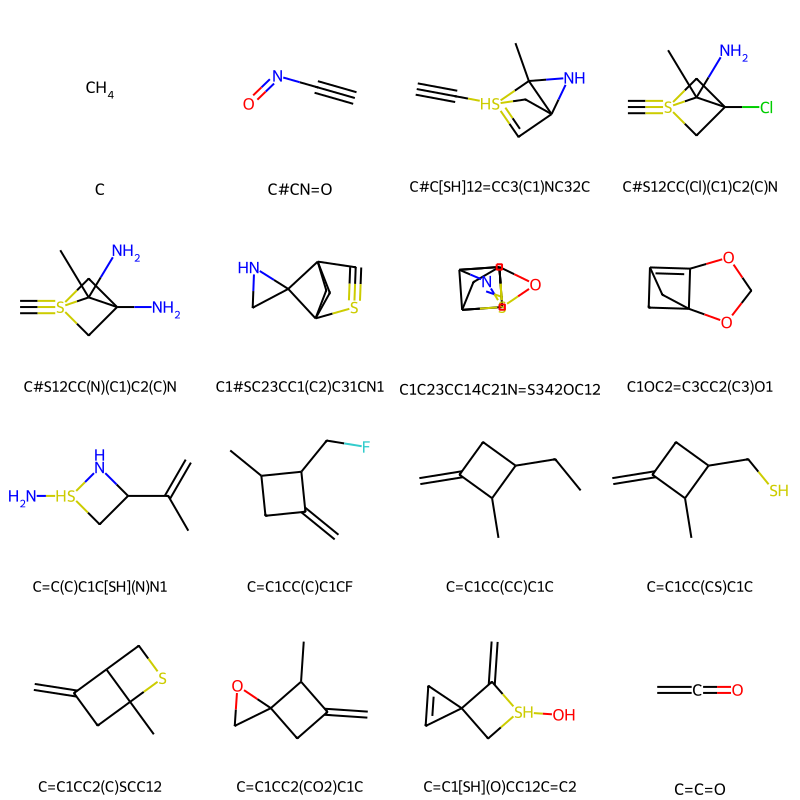

In [6]:
from rdkit.Chem import Draw

def visualize_v3(epoch, num_to_show=16):
    filepath = os.path.join(Config.MODEL_DIR, f'final_molecules_ep{epoch}_v3.csv')
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return
    
    df = pd.read_csv(filepath)
    smiles = df['smiles'][:num_to_show].tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=smiles)

# Visualize
visualize_v3(460)

SA Score module loaded successfully.
Loading molecules from models_simplified_v3\final_molecules_ep460_v3.csv...
Calculating physicochemical properties...

--- Summary Statistics of Generated Molecules ---
            MW     LogP      QED     TPSA      HBD      HBA  SA_Score
count  266.000  266.000  266.000  266.000  266.000  266.000   266.000
mean   133.903    0.961    0.439   20.032    1.015    1.342     6.334
std     23.295    0.696    0.071   14.694    0.855    0.810     1.358
min     16.043   -0.868    0.210    0.000    0.000    0.000     1.968
25%    126.465    0.435    0.381    9.230    0.000    1.000     5.528
50%    141.239    1.050    0.454   20.230    1.000    1.000     6.749
75%    144.554    1.438    0.497   29.330    2.000    2.000     7.309
max    184.351    2.833    0.578   52.320    4.000    4.000     8.640

Plotting property distributions...


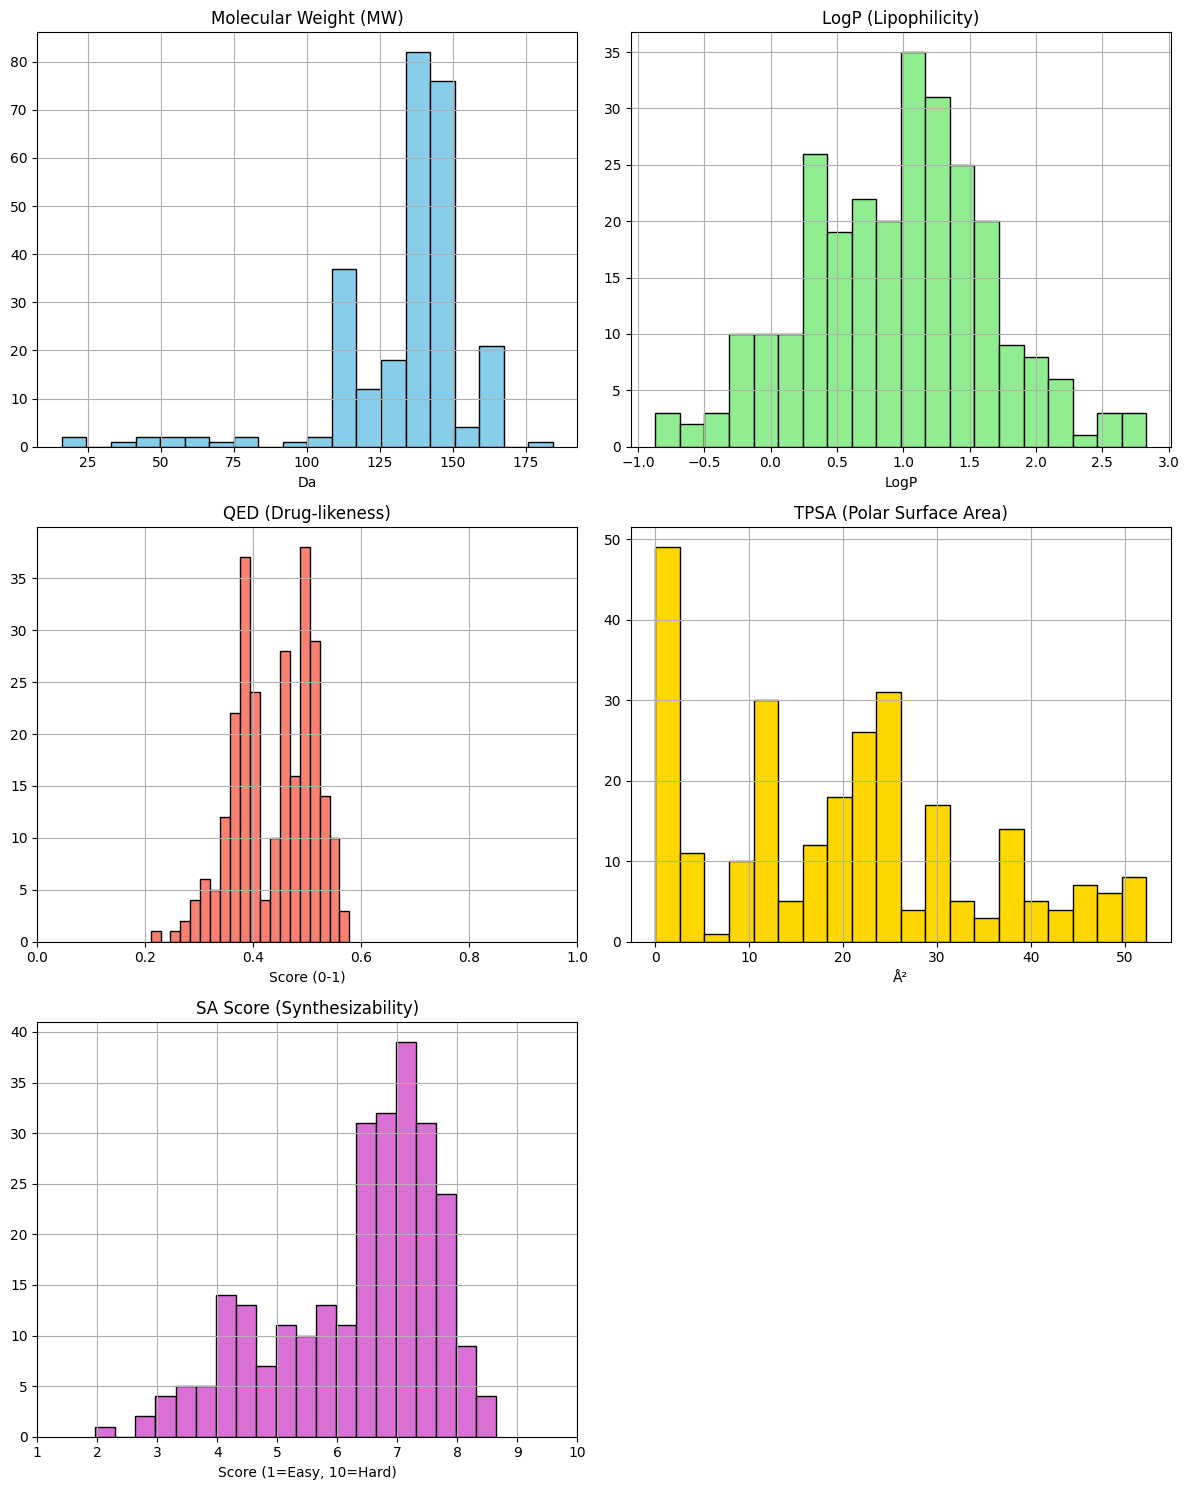


Visualizing 8 molecules with highest QED (most drug-like)...


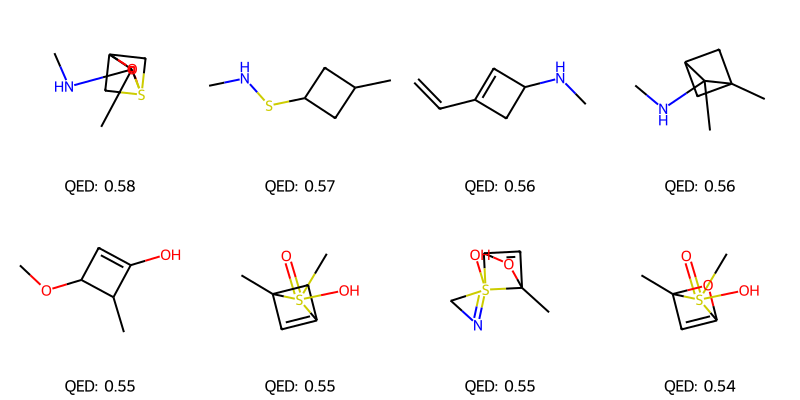

In [8]:
import os
import sys
import pandas as pd
import numpy as np
import os.path as op
from rdkit import Chem, RDConfig
from rdkit.Chem import Descriptors, QED, Draw
import matplotlib.pyplot as plt
from IPython.display import display

# --- Import SA Score ---
sys.path.append(op.join(RDConfig.RDContribDir, 'SA_Score'))
try:
    import sascorer
    SA_SCORE_ENABLED = True
    print("SA Score module loaded successfully.")
except ImportError:
    print("SA Score module not found. Skipping SA_Score calculation.")
    SA_SCORE_ENABLED = False

# --- Configuration ---
class Config:
    MODEL_DIR = 'models_simplified_v3' 
# ---

def analyze_generated_molecules(csv_path):
    if not os.path.exists(csv_path):
        print(f"Error: CSV file not found at {csv_path}")
        return

    print(f"Loading molecules from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # 1. Create Molecule Objects & Filter
    print("Calculating physicochemical properties...")
    # Create a temporary column for RDKit molecule objects
    df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
    
    # Drop any rows where 'mol' is None (failed to parse)
    original_len = len(df)
    df_clean = df.dropna(subset=['mol']).copy()
    dropped_count = original_len - len(df_clean)
    if dropped_count > 0:
        print(f"Warning: Dropped {dropped_count} invalid SMILES strings.")
    
    if len(df_clean) == 0:
        print("No valid molecules to analyze.")
        return

    # 2. Calculate Properties on the clean DataFrame
    df_clean['MW'] = df_clean['mol'].apply(Descriptors.MolWt)
    df_clean['LogP'] = df_clean['mol'].apply(Descriptors.MolLogP)
    df_clean['QED'] = df_clean['mol'].apply(QED.qed)
    df_clean['TPSA'] = df_clean['mol'].apply(Descriptors.TPSA)
    df_clean['HBD'] = df_clean['mol'].apply(Descriptors.NumHDonors)
    df_clean['HBA'] = df_clean['mol'].apply(Descriptors.NumHAcceptors)
    if SA_SCORE_ENABLED:
        df_clean['SA_Score'] = df_clean['mol'].apply(sascorer.calculateScore)

    # 3. Summary Statistics
    print("\n--- Summary Statistics of Generated Molecules ---")
    # Drop 'mol' column for clean description, include only numeric columns
    print(df_clean.drop(columns=['mol']).describe().round(3))

    # 4. Visualization of Distributions
    print("\nPlotting property distributions...")
    plot_rows = 3 if SA_SCORE_ENABLED else 2
    fig, axes = plt.subplots(plot_rows, 2, figsize=(12, 5 * plot_rows))
    
    # Helper to make plotting safer if axes array shape changes
    ax_flat = axes.flatten()
    
    df_clean['MW'].hist(ax=ax_flat[0], bins=20, color='skyblue', edgecolor='black')
    ax_flat[0].set_title('Molecular Weight (MW)')
    ax_flat[0].set_xlabel('Da')

    df_clean['LogP'].hist(ax=ax_flat[1], bins=20, color='lightgreen', edgecolor='black')
    ax_flat[1].set_title('LogP (Lipophilicity)')
    ax_flat[1].set_xlabel('LogP')

    df_clean['QED'].hist(ax=ax_flat[2], bins=20, color='salmon', edgecolor='black')
    ax_flat[2].set_title('QED (Drug-likeness)')
    ax_flat[2].set_xlabel('Score (0-1)'); ax_flat[2].set_xlim(0, 1)

    df_clean['TPSA'].hist(ax=ax_flat[3], bins=20, color='gold', edgecolor='black')
    ax_flat[3].set_title('TPSA (Polar Surface Area)')
    ax_flat[3].set_xlabel('Å²')
    
    if SA_SCORE_ENABLED:
        df_clean['SA_Score'].hist(ax=ax_flat[4], bins=20, color='orchid', edgecolor='black')
        ax_flat[4].set_title('SA Score (Synthesizability)')
        ax_flat[4].set_xlabel('Score (1=Easy, 10=Hard)'); ax_flat[4].set_xlim(1, 10)
        ax_flat[5].axis('off') # Hide empty subplot

    plt.tight_layout()
    plt.show()

    # 5. Visualize Best by QED
    print("\nVisualizing 8 molecules with highest QED (most drug-like)...")
    top_qed = df_clean.nlargest(8, 'QED')
    img = Draw.MolsToGridImage(top_qed['mol'].tolist(), 
                               molsPerRow=4, subImgSize=(200,200), 
                               legends=[f"QED: {q:.2f}" for q in top_qed['QED']])
    display(img)

# --- Run the analysis ---
csv_path = os.path.join('models_simplified_v3', 'final_molecules_ep460_v3.csv') 
analyze_generated_molecules(csv_path)

In [10]:
import pandas as pd
import sqlite3
import os

# --- Minimal Config for this script ---
CHEMPL_DB_PATH = 'DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db'
MODEL_DIR = 'models_simplified_v3'
GENERATED_FILE = 'final_molecules_ep460_v3.csv'
# ------------------------------------

def check_novelty():
    # 1. Load Training Data
    if not os.path.exists(CHEMPL_DB_PATH):
        print(f"Error: ChEMBL DB not found at {CHEMPL_DB_PATH}")
        return

    print("Loading original ChEMBL training candidates...")
    try:
        conn = sqlite3.connect(CHEMPL_DB_PATH)
        cursor = conn.cursor()
        # Exact same query used in training to get the candidate pool
        cursor.execute("SELECT canonical_smiles FROM compound_structures WHERE length(canonical_smiles) < 50 LIMIT 200000")
        training_smiles = set([row[0] for row in cursor.fetchall()])
        conn.close()
        print(f"Loaded {len(training_smiles)} unique training SMILES.")
    except Exception as e:
        print(f"Database error: {e}")
        return

    # 2. Load Generated SMILES
    gen_path = os.path.join(MODEL_DIR, GENERATED_FILE)
    if not os.path.exists(gen_path):
        print(f"Error: Generated file not found at {gen_path}")
        return
    
    df_gen = pd.read_csv(gen_path)
    generated_smiles = set(df_gen['smiles'].tolist())
    print(f"Loaded {len(generated_smiles)} unique generated SMILES from Epoch 460.")

    # 3. Calculate Novelty
    # Novelty = Molecules in Generated set that are NOT in Training set
    novel_molecules = generated_smiles - training_smiles
    novelty_score = (len(novel_molecules) / len(generated_smiles)) * 100

    print(f"\n--- NOVELTY RESULTS ---")
    print(f"Total Generated: {len(generated_smiles)}")
    print(f"Novel Molecules Created: {len(novel_molecules)}")
    print(f"Novelty Score: {novelty_score:.2f}%")
    
    if len(novel_molecules) > 0:
        print("\nSample Novel Molecules (Not in ChEMBL subset):")
        # Print top 5 longest ones as they are often more interesting than tiny fragments
        sorted_novel = sorted(list(novel_molecules), key=len, reverse=True)
        for s in sorted_novel[:5]:
            print(f"  - {s}")

check_novelty()

Loading original ChEMBL training candidates...
Loaded 199992 unique training SMILES.
Loaded 267 unique generated SMILES from Epoch 460.

--- NOVELTY RESULTS ---
Total Generated: 267
Novel Molecules Created: 266
Novelty Score: 99.63%

Sample Novel Molecules (Not in ChEMBL subset):
  - C[SH]12=CC(=C1)[SH]2(C)(O)S
  - CC12C3=[SH]S14(C)=C1C2C314
  - CC12C3=C[SH]145C1C2C34C15
  - CC12C3=C[SH]145C1C2C34N15
  - CC12CC34C1[SH]3[SH]241CC1


Loading generated molecules...
Calculating fingerprints for 266 molecules...
Calculating pairwise Tanimoto similarities...

--- INTERNAL DIVERSITY RESULTS ---
Average Tanimoto Similarity: 0.1170
Internal Diversity Score:      0.8830
(Closer to 1.0 is more diverse, closer to 0.0 is less diverse)


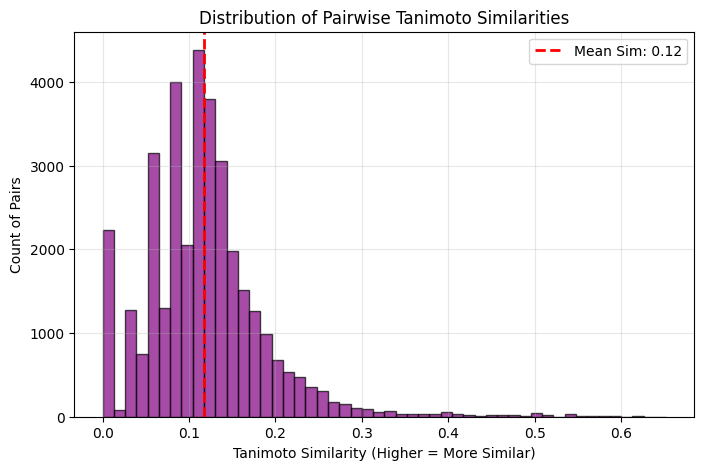

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm

# --- Configuration matches your previous runs ---
MODEL_DIR = 'models_simplified_v3'
GENERATED_FILE = 'final_molecules_ep460_v3.csv'
# ----------------------------------------------

def analyze_internal_diversity():
    gen_path = os.path.join(MODEL_DIR, GENERATED_FILE)
    if not os.path.exists(gen_path):
        print(f"Error: File not found at {gen_path}")
        return

    print("Loading generated molecules...")
    df = pd.read_csv(gen_path)
    mols = [Chem.MolFromSmiles(s) for s in df['smiles']]
    mols = [m for m in mols if m is not None]
    
    print(f"Calculating fingerprints for {len(mols)} molecules...")
    # Radius 2 is standard (equivalent to ECFP4)
    fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mols]

    print("Calculating pairwise Tanimoto similarities...")
    similarities = []
    num_mols = len(fps)
    for i in range(num_mols):
        # Compare each molecule only with those after it to avoid duplicates/self-comparisons
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[i+1:])
        similarities.extend(sims)

    similarities = np.array(similarities)
    avg_sim = np.mean(similarities)
    
    # Internal Diversity is often defined as 1 - Average Similarity
    internal_diversity = 1.0 - avg_sim

    print(f"\n--- INTERNAL DIVERSITY RESULTS ---")
    print(f"Average Tanimoto Similarity: {avg_sim:.4f}")
    print(f"Internal Diversity Score:      {internal_diversity:.4f}")
    print("(Closer to 1.0 is more diverse, closer to 0.0 is less diverse)")

    # Plot distribution
    plt.figure(figsize=(8, 5))
    plt.hist(similarities, bins=50, color='purple', alpha=0.7, edgecolor='black')
    plt.axvline(x=avg_sim, color='red', linestyle='--', linewidth=2, label=f'Mean Sim: {avg_sim:.2f}')
    plt.title('Distribution of Pairwise Tanimoto Similarities')
    plt.xlabel('Tanimoto Similarity (Higher = More Similar)')
    plt.ylabel('Count of Pairs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

analyze_internal_diversity()

Loading training data subset...
Generating fingerprints for Real (ChEMBL)...


100%|██████████| 2000/2000 [00:00<00:00, 6208.54it/s]


Generating fingerprints for Generated (WGAN-GP)...


100%|██████████| 267/267 [00:00<00:00, 11070.48it/s]


Running PCA to reduce dimensions to 2D...


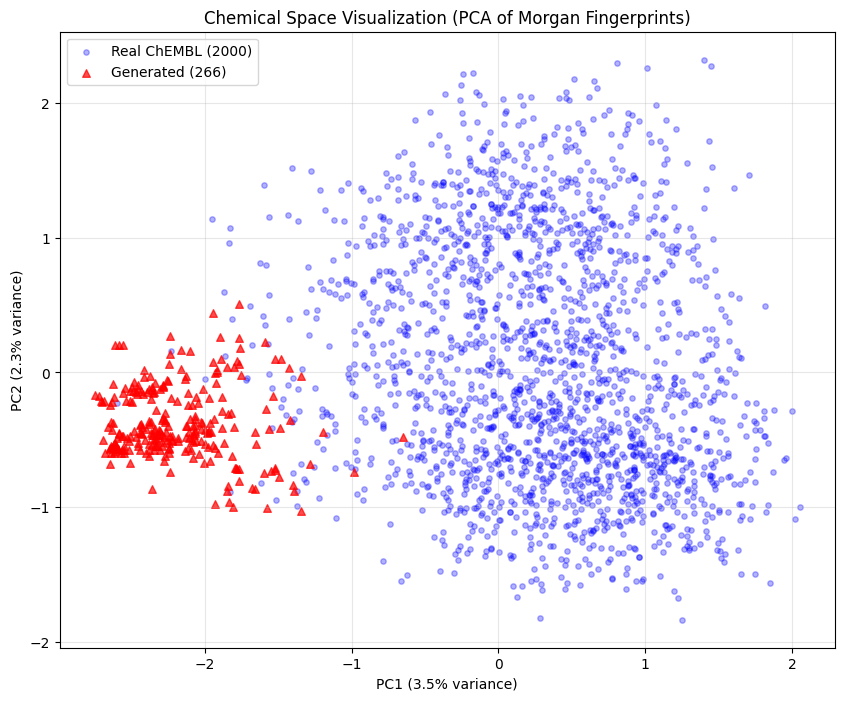

In [13]:
import numpy as np
import pandas as pd
import sqlite3
import os
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config matches previous runs ---
CHEMPL_DB_PATH = 'DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db'
MODEL_DIR = 'models_simplified_v3'
GENERATED_FILE = 'final_molecules_ep460_v3.csv'
# ----------------------------------

def get_fingerprints(smiles_list, label):
    fps = []
    valid_indices = []
    print(f"Generating fingerprints for {label}...")
    for i, smi in enumerate(tqdm(smiles_list)):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                # Generate Morgan fingerprint (radius 2, 2048 bits)
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                # Convert to numpy array for PCA
                arr = np.zeros((0,), dtype=np.int8)
                DataStructs.ConvertToNumpyArray(fp, arr)
                fps.append(arr)
                valid_indices.append(i)
        except:
            continue
    return np.array(fps)

def visualize_chemical_space():
    # 1. Load a subset of REAL Training Data
    print("Loading training data subset...")
    conn = sqlite3.connect(CHEMPL_DB_PATH)
    # Get 2000 random small molecules from ChEMBL to represent "real" space
    query = "SELECT canonical_smiles FROM compound_structures WHERE length(canonical_smiles) < 50 ORDER BY RANDOM() LIMIT 2000"
    real_smiles = [row[0] for row in conn.execute(query).fetchall()]
    conn.close()

    # 2. Load GENERATED Data
    gen_path = os.path.join(MODEL_DIR, GENERATED_FILE)
    if not os.path.exists(gen_path):
        print(f"Error: {gen_path} not found.")
        return
    gen_smiles = pd.read_csv(gen_path)['smiles'].tolist()

    # 3. Compute Fingerprints
    real_fps = get_fingerprints(real_smiles, "Real (ChEMBL)")
    gen_fps = get_fingerprints(gen_smiles, "Generated (WGAN-GP)")

    # 4. Run PCA
    print("Running PCA to reduce dimensions to 2D...")
    # Combine data for unified PCA space
    all_fps = np.concatenate([real_fps, gen_fps], axis=0)
    pca = PCA(n_components=2)
    all_pcs = pca.fit_transform(all_fps)

    # Split back up for plotting
    real_pcs = all_pcs[:len(real_fps)]
    gen_pcs = all_pcs[len(real_fps):]

    # 5. Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(real_pcs[:, 0], real_pcs[:, 1], c='blue', alpha=0.3, label=f'Real ChEMBL ({len(real_pcs)})', s=15)
    plt.scatter(gen_pcs[:, 0], gen_pcs[:, 1], c='red', alpha=0.7, label=f'Generated ({len(gen_pcs)})', s=30, marker='^')
    
    plt.title('Chemical Space Visualization (PCA of Morgan Fingerprints)')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_chemical_space()

Reading log from models_simplified_v3\training_log.csv...


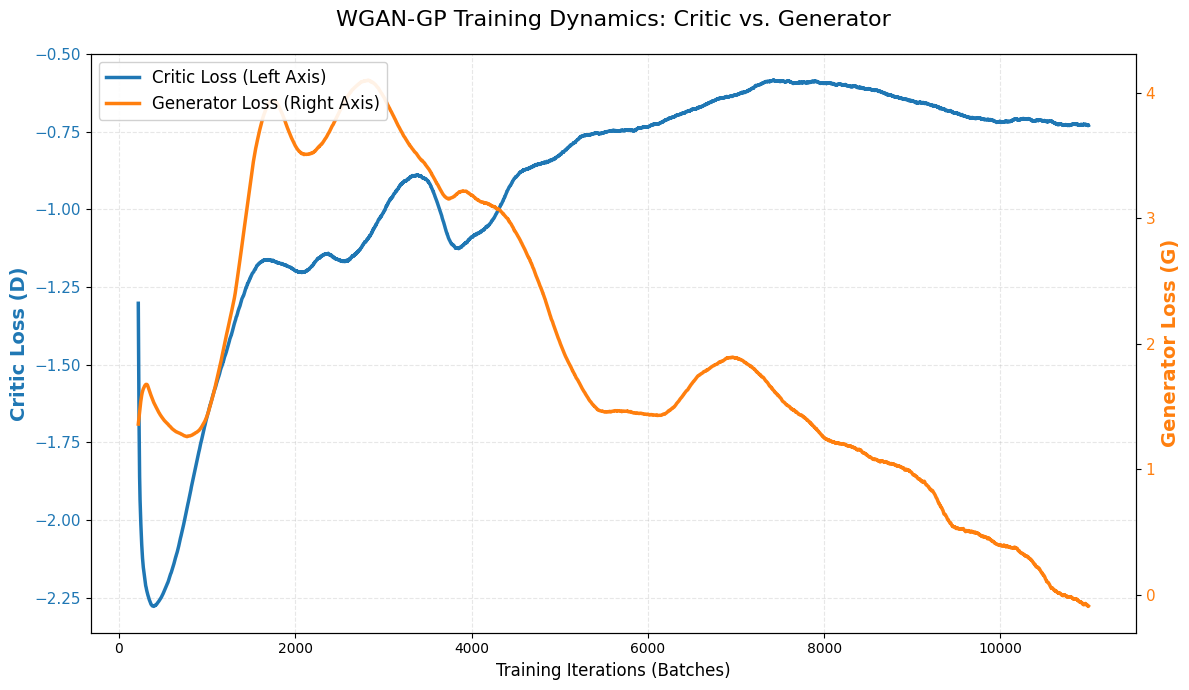

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
MODEL_DIR = 'models_simplified_v3'
LOG_FILE = 'training_log.csv'
# ---------------------

def plot_combined_loss():
    log_path = os.path.join(MODEL_DIR, LOG_FILE)
    if not os.path.exists(log_path):
        print(f"Error: Log file not found at {log_path}")
        return

    print(f"Reading log from {log_path}...")
    df = pd.read_csv(log_path)
    
    # Smoothing window (adjust higher for smoother lines, lower for more detail)
    window = max(50, len(df) // 50) 
    
    # Create combined plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # --- Axis 1: Discriminator (Left, Blue) ---
    color_d = 'tab:blue'
    ax1.set_xlabel('Training Iterations (Batches)', fontsize=12)
    ax1.set_ylabel('Critic Loss (D)', color=color_d, fontsize=14, fontweight='bold')
    l1, = ax1.plot(df['D_loss'].rolling(window).mean(), color=color_d, linewidth=2.5, label='Critic Loss (D)')
    ax1.tick_params(axis='y', labelcolor=color_d, labelsize=11)
    ax1.grid(True, linestyle='--', alpha=0.3)

    # --- Axis 2: Generator (Right, Orange) ---
    ax2 = ax1.twinx()  # Share the same x-axis
    color_g = 'tab:orange'
    ax2.set_ylabel('Generator Loss (G)', color=color_g, fontsize=14, fontweight='bold')
    l2, = ax2.plot(df['G_loss'].rolling(window).mean(), color=color_g, linewidth=2.5, label='Generator Loss (G)')
    ax2.tick_params(axis='y', labelcolor=color_g, labelsize=11)

    # --- Combined Title & Legend ---
    plt.title('WGAN-GP Training Dynamics: Critic vs. Generator', fontsize=16, pad=20)
    plt.legend([l1, l2], ['Critic Loss (Left Axis)', 'Generator Loss (Right Axis)'], 
               loc='upper left', fontsize=12, frameon=True, facecolor='white', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()

plot_combined_loss()

Reading log from models_simplified_v3\training_log.csv...


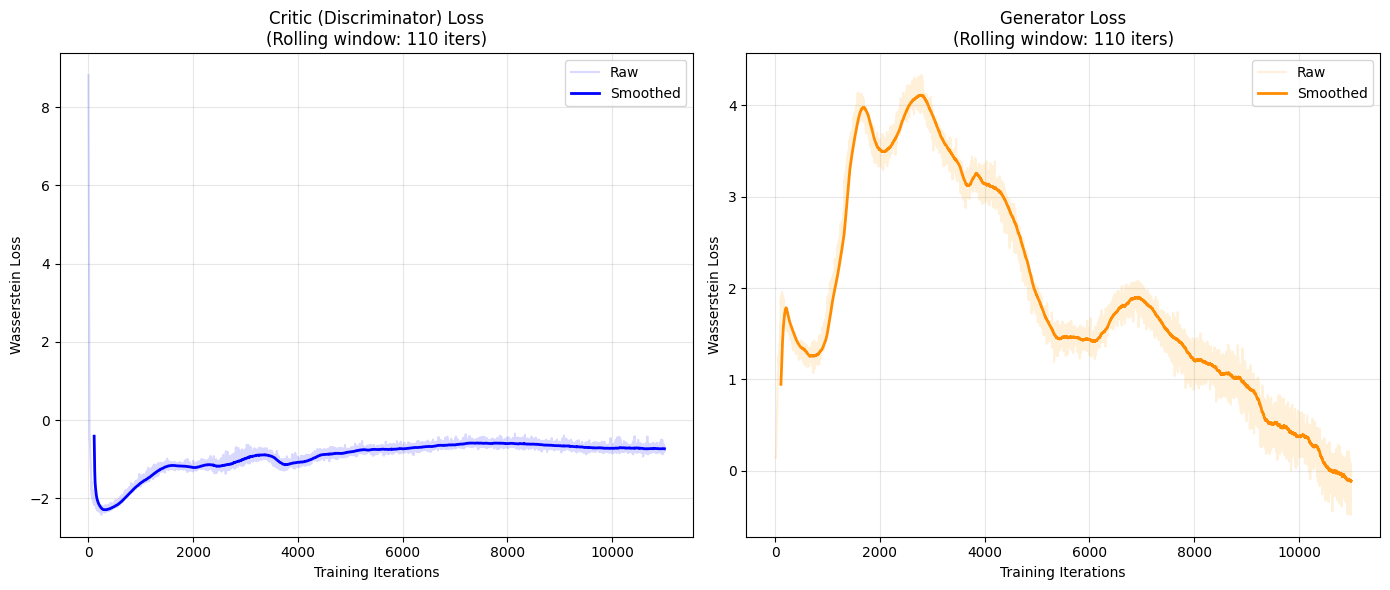

Total training iterations: 11000


In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration for this plot ---
MODEL_DIR = 'models_simplified_v3'
LOG_FILE = 'training_log.csv'
# -----------------------------------

def plot_loss_history():
    log_path = os.path.join(MODEL_DIR, LOG_FILE)
    if not os.path.exists(log_path):
        print(f"Error: Log file not found at {log_path}")
        return

    print(f"Reading log from {log_path}...")
    try:
        df = pd.read_csv(log_path)
        
        # Calculate rolling averages for smoother plots
        # Window size = 1% of total data points is usually a good balance
        window = max(50, len(df) // 100) 
        df['D_smooth'] = df['D_loss'].rolling(window=window).mean()
        df['G_smooth'] = df['G_loss'].rolling(window=window).mean()

        plt.figure(figsize=(14, 6))

        # --- PLOT 1: Discriminator Loss ---
        plt.subplot(1, 2, 1)
        plt.title(f'Critic (Discriminator) Loss\n(Rolling window: {window} iters)')
        plt.plot(df['D_loss'], color='blue', alpha=0.15, label='Raw')
        plt.plot(df['D_smooth'], color='blue', linewidth=2, label='Smoothed')
        plt.xlabel('Training Iterations')
        plt.ylabel('Wasserstein Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # --- PLOT 2: Generator Loss ---
        plt.subplot(1, 2, 2)
        plt.title(f'Generator Loss\n(Rolling window: {window} iters)')
        plt.plot(df['G_loss'], color='orange', alpha=0.15, label='Raw')
        plt.plot(df['G_smooth'], color='darkorange', linewidth=2, label='Smoothed')
        plt.xlabel('Training Iterations')
        plt.ylabel('Wasserstein Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        
        print(f"Total training iterations: {len(df)}")

    except Exception as e:
        print(f"An error occurred while plotting: {e}")

plot_loss_history()

Reading log from models_simplified_v3\training_log.csv...


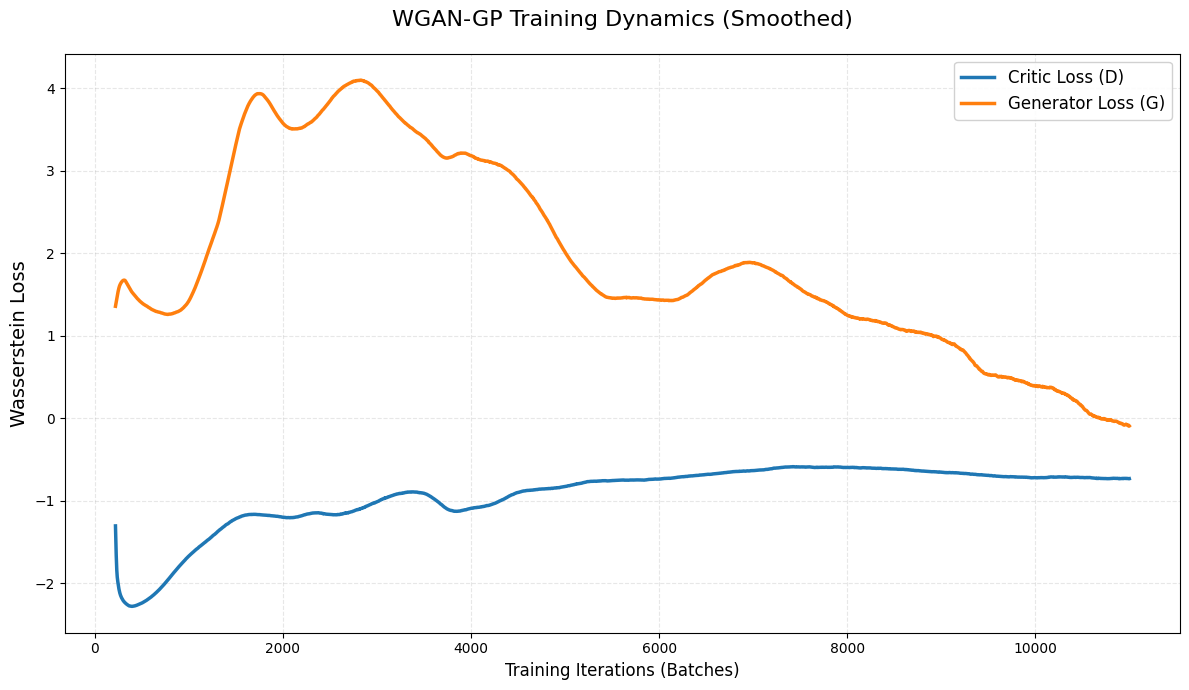

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
MODEL_DIR = 'models_simplified_v3'
LOG_FILE = 'training_log.csv'
# ---------------------

def plot_single_axis_loss():
    log_path = os.path.join(MODEL_DIR, LOG_FILE)
    if not os.path.exists(log_path):
        print(f"Error: Log file not found at {log_path}")
        return

    print(f"Reading log from {log_path}...")
    df = pd.read_csv(log_path)
    
    # Smoothing window (larger window = smoother lines)
    window = max(50, len(df) // 50) 
    
    plt.figure(figsize=(12, 7))

    # Plot smoothed Critic Loss
    plt.plot(df['D_loss'].rolling(window).mean(), 
             color='tab:blue', linewidth=2.5, label='Critic Loss (D)')

    # Plot smoothed Generator Loss
    plt.plot(df['G_loss'].rolling(window).mean(), 
             color='tab:orange', linewidth=2.5, label='Generator Loss (G)')

    # Formatting
    plt.title('WGAN-GP Training Dynamics (Smoothed)', fontsize=16, pad=20)
    plt.xlabel('Training Iterations (Batches)', fontsize=12)
    plt.ylabel('Wasserstein Loss', fontsize=14)
    plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=0.9)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    plt.show()

plot_single_axis_loss()

In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from rdkit import Chem

def generate_final_dataset_v3(best_epoch, num_samples=1000, temperature=0.8):
    gen = Generator().to(Config.DEVICE)
    model_path = os.path.join(Config.MODEL_DIR, f'g_{best_epoch}.pth')
    
    if not os.path.exists(model_path):
        print(f"Error: Checkpoint for epoch {best_epoch} not found at {model_path}")
        return

    gen.load_state_dict(torch.load(model_path, map_location=Config.DEVICE))
    gen.eval()
    valid_smiles = []
    print(f"Generating {num_samples} molecules from epoch {best_epoch}...")
    
    with torch.no_grad():
        pbar = tqdm(total=num_samples)
        while len(valid_smiles) < num_samples:
            z = torch.randn(100, Config.LATENT_DIM, device=Config.DEVICE)
            nodes, adj = gen(z, temperature=temperature)
            mols = graphs_to_mols(nodes, adj, hard=True)
            for m in mols:
                if m:
                    try:
                        smi = Chem.MolToSmiles(m)
                        if len(smi) > 0 and '.' not in smi:
                             valid_smiles.append(smi)
                             pbar.update(1)
                    except: pass
            if len(valid_smiles) >= num_samples: break
        pbar.close()

    unique_smiles = sorted(list(set(valid_smiles)))
    df = pd.DataFrame({'smiles': unique_smiles})
    
    # UPDATED FILENAME: Includes num_samples to prevent overwriting
    output_filename = f'final_molecules_ep{best_epoch}_{num_samples}_v3.csv'
    output_path = os.path.join(Config.MODEL_DIR, output_filename)
    
    df.to_csv(output_path, index=False)
    print(f"Saved {len(unique_smiles)} unique molecules to {output_path}")

# Now you can run this safely without losing your previous 1000-sample file
generate_final_dataset_v3(best_epoch=460, num_samples=10000)

Loaded 267 original generated molecules.
Loading baseline real ChEMBL molecules...
Calculating properties for Real (Baseline)...


100%|██████████| 2000/2000 [00:02<00:00, 778.18it/s]


Calculating properties for Generated (Original)...


100%|██████████| 267/267 [00:00<00:00, 1214.07it/s]


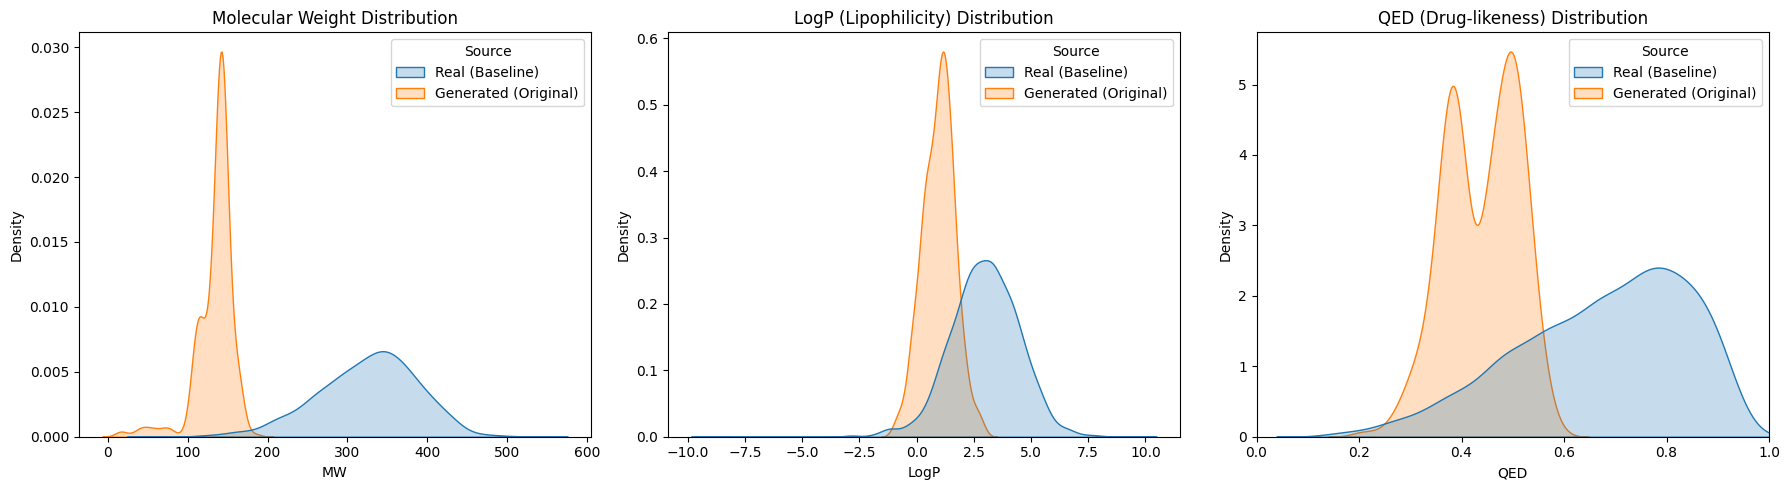


--- Mean Properties Comparison ---
                           MW   LogP    QED
Source                                     
Generated (Original)  133.903  0.961  0.439
Real (Baseline)       324.876  2.966  0.675


In [21]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
from tqdm import tqdm

# --- Configuration matches your ORIGINAL v3 run ---
CHEMPL_DB_PATH = 'DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db'
MODEL_DIR = 'models_simplified_v3'
# POINTING TO ORIGINAL FILE
GENERATED_FILE = 'final_molecules_ep460_v3.csv' 
# ----------------------------------------

def get_properties(smiles_list, label):
    props = {'MW': [], 'LogP': [], 'QED': []}
    print(f"Calculating properties for {label}...")
    for smi in tqdm(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                props['MW'].append(Descriptors.MolWt(mol))
                props['LogP'].append(Descriptors.MolLogP(mol))
                props['QED'].append(QED.qed(mol))
        except: continue
    return pd.DataFrame(props)

def plot_comparative_distributions():
    if not os.path.exists(CHEMPL_DB_PATH):
        print(f"Error: DB not found at {CHEMPL_DB_PATH}")
        return

    # 1. Load Generated Data FIRST to know how many we have
    gen_path = os.path.join(MODEL_DIR, GENERATED_FILE)
    if not os.path.exists(gen_path):
        print(f"Error: Generated file not found at {gen_path}")
        return
    df_gen_load = pd.read_csv(gen_path)
    gen_smiles = df_gen_load['smiles'].tolist()
    num_gen = len(gen_smiles)
    print(f"Loaded {num_gen} original generated molecules.")

    # 2. Load a matching number of REAL molecules for fair comparison
    # (Or keep 10k for a smoother baseline, let's use 2000 for a good representative baseline)
    print("Loading baseline real ChEMBL molecules...")
    conn = sqlite3.connect(CHEMPL_DB_PATH)
    query = "SELECT canonical_smiles FROM compound_structures WHERE length(canonical_smiles) < 50 ORDER BY RANDOM() LIMIT 2000"
    real_smiles = [row[0] for row in conn.execute(query).fetchall()]
    conn.close()

    # 3. Calculate Properties
    df_real = get_properties(real_smiles, "Real (Baseline)")
    df_gen = get_properties(gen_smiles, "Generated (Original)")
    
    df_real['Source'] = 'Real (Baseline)'
    df_gen['Source'] = 'Generated (Original)'
    df_combined = pd.concat([df_real, df_gen])

    # 4. Plot Comparisons
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    # Use 'kde' for smooth distributions, but 'hist' might be better if dataset is very small (<100)
    plot_type = sns.kdeplot if num_gen > 100 else sns.histplot
    kw_args = {'fill': True, 'common_norm': False} if num_gen > 100 else {'kde': True, 'stat': 'density', 'common_norm': False}

    sns.kdeplot(data=df_combined, x='MW', hue='Source', ax=axes[0], **kw_args)
    axes[0].set_title('Molecular Weight Distribution')

    sns.kdeplot(data=df_combined, x='LogP', hue='Source', ax=axes[1], **kw_args)
    axes[1].set_title('LogP (Lipophilicity) Distribution')

    sns.kdeplot(data=df_combined, x='QED', hue='Source', ax=axes[2], **kw_args)
    axes[2].set_title('QED (Drug-likeness) Distribution')
    axes[2].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()
    
    print("\n--- Mean Properties Comparison ---")
    print(df_combined.groupby('Source').mean().round(3))

plot_comparative_distributions()

In [22]:
import pandas as pd
import os
import sqlite3
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from tqdm import tqdm

# --- Config ---
CHEMPL_DB_PATH = 'DL_ENDSEM__DATASET/chembl_35/chembl_35_sqlite/chembl_35.db'
MODEL_DIR = 'models_simplified_v3'
GENERATED_FILE = 'final_molecules_ep460_v3.csv'
# --------------

def get_scaffolds(smiles_list):
    scaffolds = set()
    for s in tqdm(smiles_list, desc="Extracting Scaffolds"):
        try:
            mol = Chem.MolFromSmiles(s)
            if mol:
                # Extract Murcko Scaffold (standard definition of a "core" structure)
                core = MurckoScaffold.GetScaffoldForMol(mol)
                scaffolds.add(Chem.MolToSmiles(core))
        except: continue
    return scaffolds

def analyze_scaffolds():
    if not os.path.exists(CHEMPL_DB_PATH): return
    
    # 1. Get Training Scaffolds (from a subset for speed)
    print("Loading training data for scaffold analysis...")
    conn = sqlite3.connect(CHEMPL_DB_PATH)
    query = "SELECT canonical_smiles FROM compound_structures WHERE length(canonical_smiles) < 50 LIMIT 50000"
    train_smiles = [row[0] for row in conn.execute(query).fetchall()]
    conn.close()
    train_scaffolds = get_scaffolds(train_smiles)
    print(f"Found {len(train_scaffolds)} unique scaffolds in training subset.")

    # 2. Get Generated Scaffolds
    gen_path = os.path.join(MODEL_DIR, GENERATED_FILE)
    gen_smiles = pd.read_csv(gen_path)['smiles'].tolist()
    gen_scaffolds = get_scaffolds(gen_smiles)
    print(f"Found {len(gen_scaffolds)} unique scaffolds in generated set.")

    # 3. Compare
    novel_scaffolds = gen_scaffolds - train_scaffolds
    novelty_rate = (len(novel_scaffolds) / len(gen_scaffolds)) * 100 if len(gen_scaffolds) > 0 else 0

    print(f"\n--- SCAFFOLD ANALYSIS ---")
    print(f"Novel Scaffolds Created: {len(novel_scaffolds)}")
    print(f"Scaffold Novelty Rate:   {novelty_rate:.1f}%")

analyze_scaffolds()

Loading training data for scaffold analysis...


Extracting Scaffolds: 100%|██████████| 50000/50000 [00:08<00:00, 5803.83it/s]


Found 20049 unique scaffolds in training subset.


Extracting Scaffolds: 100%|██████████| 267/267 [00:00<00:00, 10550.07it/s]

Found 178 unique scaffolds in generated set.

--- SCAFFOLD ANALYSIS ---
Novel Scaffolds Created: 173
Scaffold Novelty Rate:   97.2%
